# Bayesian Optimization for Rosenbrock Function

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from scipy.optimize import rosen

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append("..")
from bayesian_optimization import (BayesianOptimizer, GaussianProcessModel,
    UpperConfidenceBound)

### Objective Function

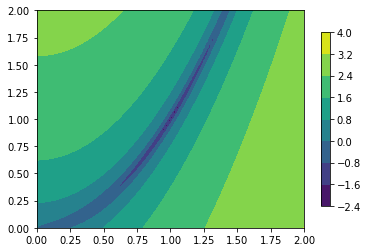

In [5]:
# Plot true function
xi = np.linspace(0, 2, 100)
yi = np.linspace(0, 2, 100)
Xi, Yi = np.meshgrid(xi, yi)

Zi = np.array([np.log10(rosen([xi_, yi_])) for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
CS = plt.contourf(Xi, Yi, Zi)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

### Gaussian Process

In [6]:
x = np.random.uniform(0, 2, size=(2, 100))
y = rosen(x)

Learned kernel: 100**2 * RBF(length_scale=[0.287, 0.781])


Text(0.5, 1.0, 'Learned GP model on 100 training datapoints')

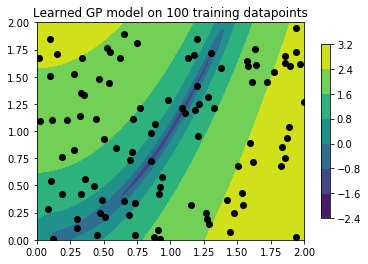

In [7]:
kernel = C(100.0, (1.0, 10000.0)) \
    * RBF(length_scale=(1.0, 1.0), length_scale_bounds=[(0.1, 100), (0.1, 100)])

gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(x.T, y)
print("Learned kernel: %s" % gp.kernel_)

Zi = np.array([np.log10(gp.predict([[xi_, yi_]])) for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
CS = plt.contourf(Xi, Yi, Zi)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# Plot samples
plt.plot(x[0], x[1], 'ko')

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title("Learned GP model on %s training datapoints" % x.shape[1])

### Bayesian Optimization

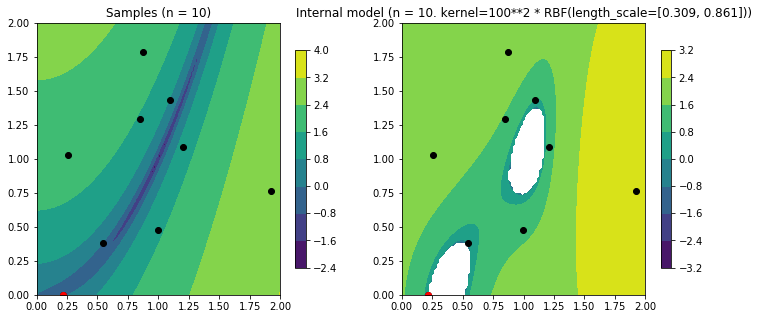

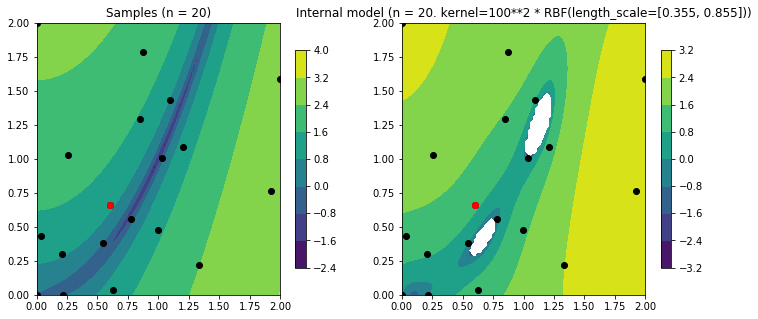

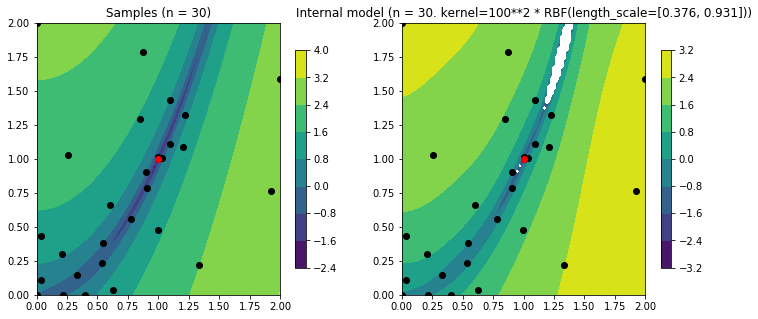

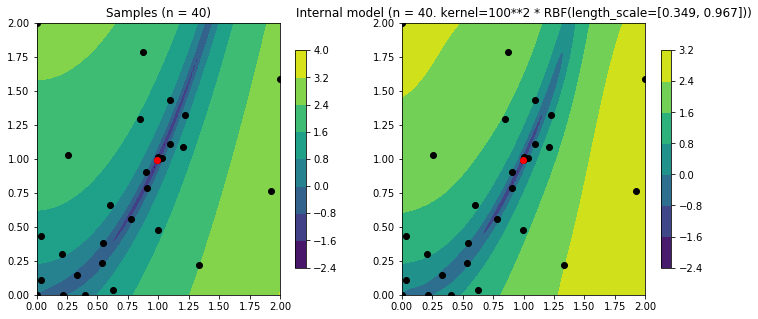

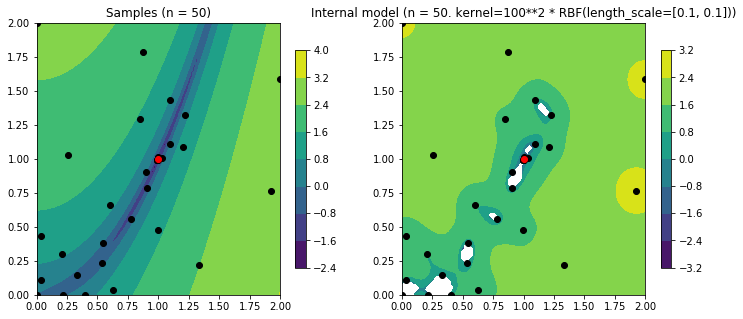

In [8]:
model = GaussianProcessModel(kernel=kernel, normalize_y=True, alpha=1e-3)
acquisition_function = UpperConfidenceBound(model, kappa=2.5)
opt = BayesianOptimizer(model=model, acquisition_function=acquisition_function,
                        optimizer="direct+lbfgs", maxf=50)

scores = []

fig_counter = 0
for step in range(50):
    if (step + 1) % 10 == 0:
        plt.figure(fig_counter, figsize=(12, 5))
        fig_counter += 1

        # Plot true function
        plt.subplot(1, 2, 1)
        xi = np.linspace(0, 2, 100)
        yi = np.linspace(0, 2, 100)
        Xi, Yi = np.meshgrid(xi, yi)

        Zi = np.array([np.log10(rosen([xi_, yi_]))
                       for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
        CS = plt.contourf(Xi, Yi, Zi)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')

        # Plot samples
        thetas = np.array(opt.X_)
        plt.plot(thetas[:, 0], thetas[:, 1], 'ko')
        plt.plot(thetas[-1:, 0], thetas[-1:, 1], 'ro')

        plt.xlim(0, 2)
        plt.ylim(0, 2)
        plt.title("Samples (n = %s)" % (step + 1))

        # Plot GP model
        plt.subplot(1, 2, 2)
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp.fit(np.vstack(opt.X_), opt.y_)

        Zi = np.array([np.log10(-gp.predict([[xi_, yi_]]))
                       for yi_ in yi for xi_ in xi]).reshape(Xi.shape)
        CS = plt.contourf(Xi, Yi, Zi)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')

        # Plot samples
        plt.plot(thetas[:, 0], thetas[:, 1], 'ko')
        plt.plot(thetas[-1:, 0], thetas[-1:, 1], 'ro')

        plt.xlim(0, 2)
        plt.ylim(0, 2)
        plt.title("Internal model (n = %s. kernel=%s)" % (step + 1, gp.kernel_))

    X_query = opt.select_query_point(boundaries=[(0, 2), (0, 2)])
    y_query = -rosen(X_query)
    opt.update(X_query, y_query)

    scores.append(y_query)

Text(0.5, 1.0, 'Learning curve')

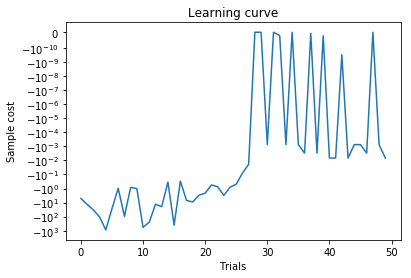

In [9]:
plt.plot(np.array(scores))
plt.yscale("symlog", linthreshy=1e-10)
plt.xlabel("Trials")
plt.ylabel("Sample cost")
plt.title("Learning curve")